In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

Load and preprocess stereo image pairs from a folder

In [2]:
def load_stereo_pairs(folder_path, left_suffix='l', right_suffix='r'):
    files = sorted(os.listdir(folder_path))
    left_images = []
    right_images = []
    # Separate left and right images
    for file in files:
        if left_suffix in file:
            left_images.append(file)
        elif right_suffix in file:
            right_images.append(file)
    left_images = sorted(left_images)
    right_images = sorted(right_images)
    # Pair the images together
    pairs = []
    for left_img_name, right_img_name in zip(left_images, right_images):
        left_path = os.path.join(folder_path, left_img_name)
        right_path = os.path.join(folder_path, right_img_name)
        left_img = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
        right_img = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)
        if left_img is None or right_img is None:
            print(f"Warning: Could not load {left_img_name} or {right_img_name}")
            continue
        pairs.append((left_img, right_img))
    return pairs


def plot_stereo_pairs(pairs, gap_width=20):
    for idx, (left_img, right_img) in enumerate(pairs):
        # Create a white gap bet the left & right images
        gap = np.ones((left_img.shape[0], gap_width), dtype=np.uint8) * 255
        # Concatenate the left image, gap & right image horizontally
        combined = np.hstack((left_img, gap, right_img))
        # Create a figure with enough size
        plt.figure(figsize=(10, 5))
        plt.title(f"Stereo Pair {idx + 1} (Left | Right)")
        plt.imshow(combined, cmap='gray')
        plt.axis('off')
        # Adjust subplot to prevent clipping
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
        # Show the image
        plt.show()

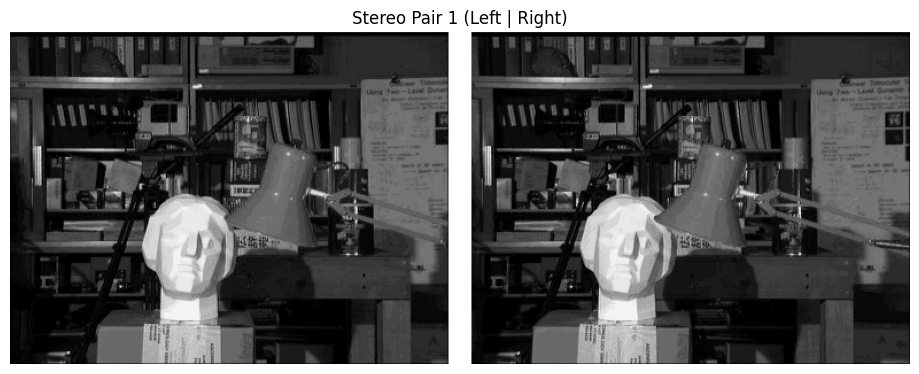

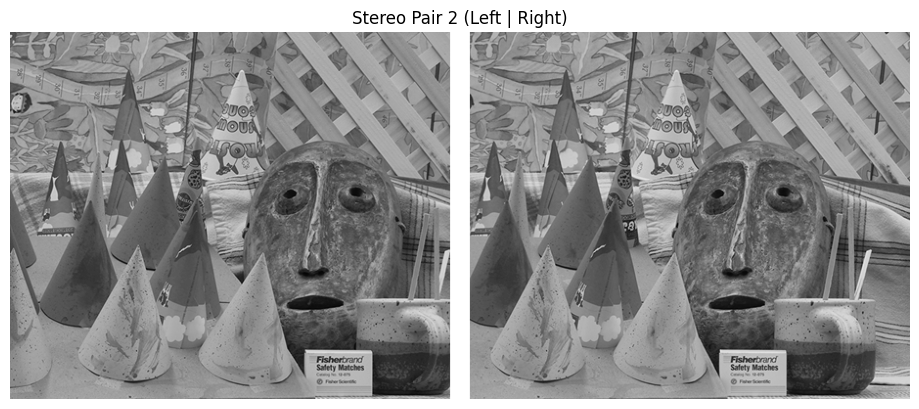

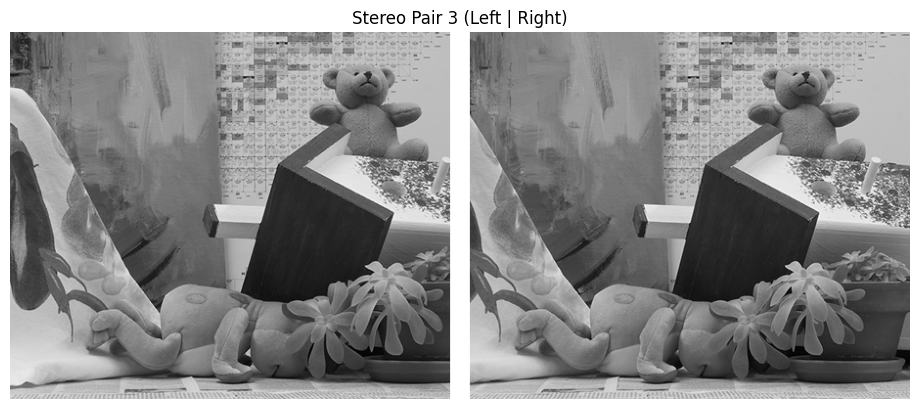

In [3]:
# Preprocessing of image pairs to be visualised 
pairs = load_stereo_pairs(folder_path=r'D:\College-MRE\Computer Vision\Lab Assig\assig3\stereo_materials')
plot_stereo_pairs(pairs)

Compute disparity by Block Matching; using SAD and SSD

In [ ]:
def compute_disparity_blockmatch(lI, rI, window_size, method, max_disp):
    # Get image dimensions
    h, w = lI.shape
    # Initialize disparity map
    disparity = np.zeros((h, w), dtype=np.float32)
    # Half window size for symmetric patch extraction
    half_w = window_size // 2

    # Loop over each pixel (excluding borders)
    for y in range(half_w, h - half_w):
        for x in range(half_w, w - half_w):
            # Best disparity for this pixel
            best_offset = 0
            # Initialize cost to a large value
            min_cost = float('inf')
            # Extract the patch from the left image centered at (x, y)
            left_patch = lI[y-half_w:y + half_w+1, x-half_w:x + half_w+1]

            # Search over possible disparities
            for d in range(min(max_disp, x - half_w)):
                # Corresponding x in the right image (same row)
                xr = x - d
                # Prevent going out of bounds on the right image
                if xr - half_w < 0:
                    continue
                # Extract the corresponding patch from the right image
                right_patch = rI[y-half_w:y + half_w+1, xr-half_w:xr + half_w+1]

                # Compute cost between patches using SAD or SSD methods
                if method == 'SAD':
                    cost = np.sum(np.abs(left_patch - right_patch))
                elif method == 'SSD':
                    cost = np.sum((left_patch - right_patch)** 2)
                else:
                    raise ValueError("Unsupported method: use 'SAD' or 'SSD'.")
                
                # Keep track of the best disparity (lowest cost)
                if cost < min_cost:
                    min_cost = cost
                    best_offset = d
            disparity[y, x] = best_offset

    # Normalize disparity map for visualization
    disparity = cv2.normalize(disparity, None, 0, 255, cv2.NORM_MINMAX)
    return disparity.astype(np.uint8)


def plot_disparity_map(disparity, title):
    # Plot the disparity map using a color heatmap
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(disparity, cmap='jet')
    plt.colorbar(label='Disparity')
    plt.axis('off')
    plt.show()

Experimenting by maximum disparity of 50 (Greyscaled)


Processing stereo pair 1...
Computing disparity (w=1, method=SAD)...


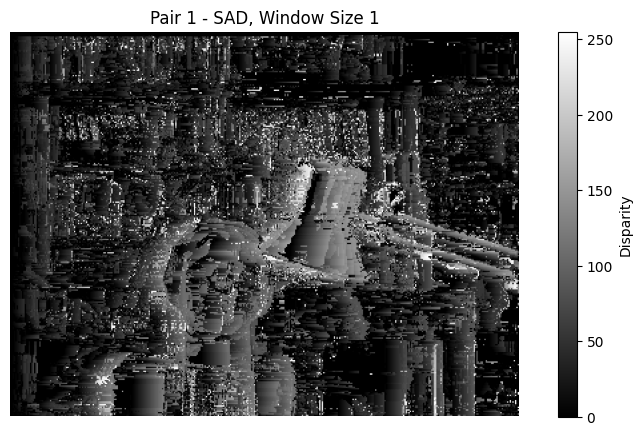

Computing disparity (w=1, method=SSD)...


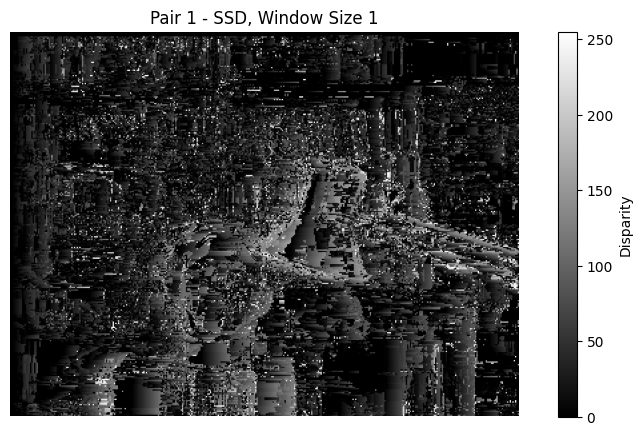

Computing disparity (w=5, method=SAD)...


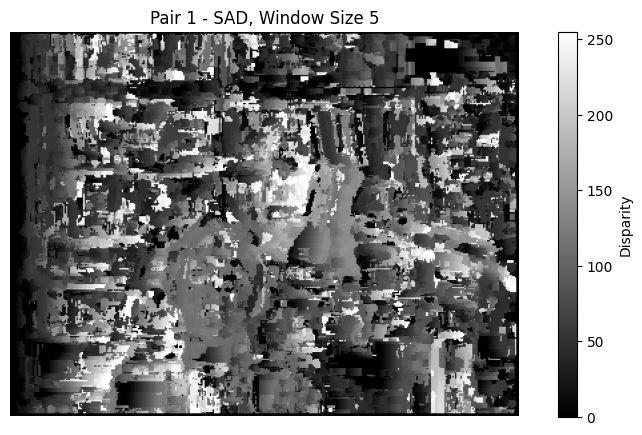

Computing disparity (w=5, method=SSD)...


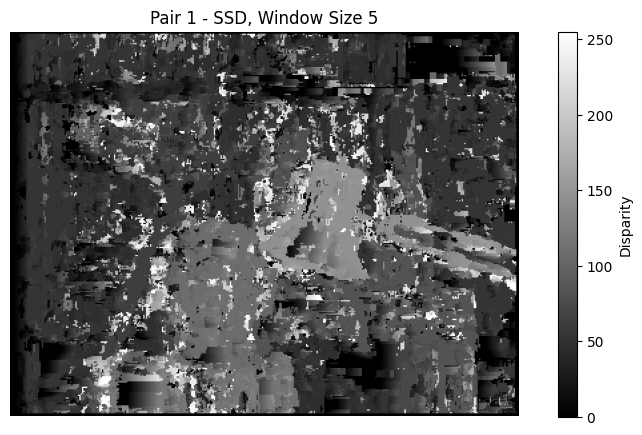

Computing disparity (w=9, method=SAD)...


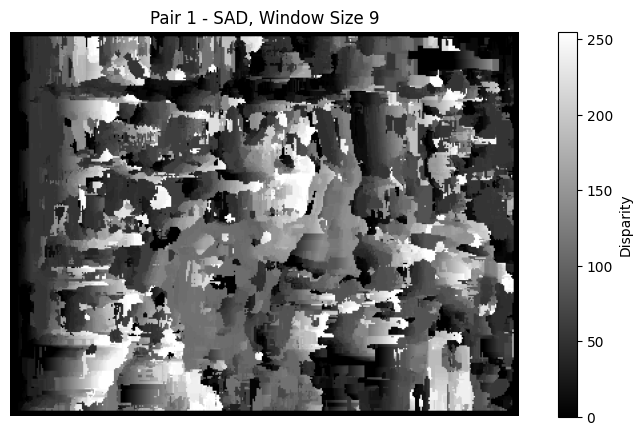

Computing disparity (w=9, method=SSD)...


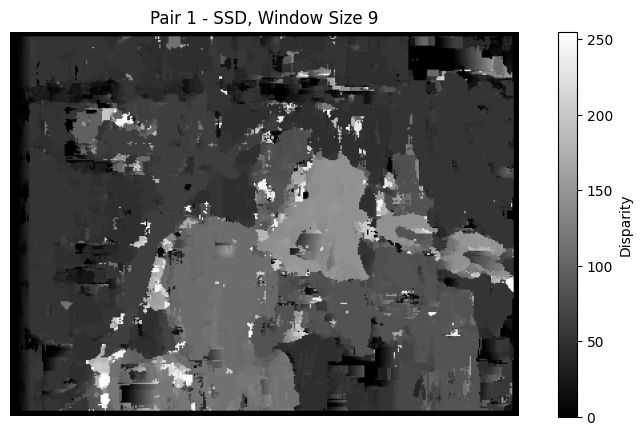

In [8]:
def plot_disparity_map_gray(disparity, title):
    # Plot the disparity map using a color heatmap
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(disparity, cmap='gray')
    plt.colorbar(label='Disparity')
    plt.axis('off')
    plt.show()

# Disparity computation for window sizes = 1, 5, 9 using both SAD & SSD
window_sizes = [1, 5, 9]
methods = ['SAD', 'SSD']

# Trial on preprocessed stereo pair (pair 1 for ex.)
print(f"\nProcessing stereo pair 1...")
for w in window_sizes:
    for method in methods:
        print(f"Computing disparity (w={w}, method={method})...")
        disp = compute_disparity_blockmatch(lI, rI, window_size=w, method=method, max_disp = 50)
        plot_disparity_map_gray(disp, title=f"Pair 1 - {method}, Window Size {w}")